In [2]:
import tarfile
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
import h5py
import matplotlib.pyplot as plt

In [3]:
tar = tarfile.open("./RML2016.10a.tar.bz2", "r:bz2")  
tar.extractall()

In [3]:
with open("RML2016.10a_dict.pkl", "rb") as p:
    dataset = pickle.load(p, encoding='latin1')

In [4]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1,0])

In [5]:
X = []  
labels = []

In [6]:
for mod in mods:
    for snr in snrs:
        X.append(dataset[(mod,snr)])
        for i in range(dataset[(mod,snr)].shape[0]):  
            labels.append((mod,snr))

In [7]:
d = np.vstack(X)

raw = d
derivative = np.gradient(d, axis=-1)
fft = np.abs(np.fft.fft(d, axis=-1))
fft_deriv = np.abs(np.fft.fft(np.gradient(d, axis=-1), axis=-1))

# Concatenate different forms of signal vectors
raw_fft = np.concatenate((raw, fft), axis=-1)
raw_fft_deriv = np.concatenate((raw, fft, fft_deriv), axis=-1)

In [8]:
# data = raw
data = derivative
# data = raw_fft
# data = raw_fft_deriv

In [9]:
np.random.seed(2016)
n_examples = data.shape[0]
n_train = n_examples * 0.8
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = data[train_idx]
X_test =  data[test_idx]

In [10]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [11]:
Y_train = to_onehot(list(map(lambda x: mods.index(labels[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(labels[x][0]), test_idx)))

In [12]:
inp_shape = list(X_train.shape[1:])
classes = mods
inp_shape

[2, 128]

In [15]:
model = models.Sequential() 
model.add(Reshape((inp_shape+[1]), input_shape=inp_shape))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(2))
model.add(Conv2D(16, (2, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax', kernel_initializer='he_normal'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 64)        256       
                                                                 
 batch_normalization_2 (Batc  (None, 2, 128, 64)       512       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 128, 16)        6160      
                                                                 
 batch_normalization_3 (Batc  (None, 2, 128, 16)       512       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [16]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
checkpoint_filepath = "best_model.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True, verbose=0)

In [18]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=100,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
1760/1760 [==============================] - 57s 32ms/step - loss: 2.0010 - accuracy: 0.2605 - val_loss: 1.8252 - val_accuracy: 0.3179
Epoch 2/10
1760/1760 [==============================] - 63s 36ms/step - loss: 1.7816 - accuracy: 0.3281 - val_loss: 1.6898 - val_accuracy: 0.3572
Epoch 3/10
1760/1760 [==============================] - 64s 36ms/step - loss: 1.6919 - accuracy: 0.3501 - val_loss: 1.6305 - val_accuracy: 0.3731
Epoch 4/10
1760/1760 [==============================] - 64s 36ms/step - loss: 1.6209 - accuracy: 0.3698 - val_loss: 1.5963 - val_accuracy: 0.3722
Epoch 5/10
1760/1760 [==============================] - 67s 38ms/step - loss: 1.5767 - accuracy: 0.3811 - val_loss: 1.5772 - val_accuracy: 0.3782
Epoch 6/10
1760/1760 [==============================] - 66s 37ms/step - loss: 1.5457 - accuracy: 0.3898 - val_loss: 1.5644 - val_accuracy: 0.3793
Epoch 7/10
1760/1760 [==============================] - 66s 37ms/step - loss: 1.5150 - accuracy: 0.4017 - val_loss: 1.5759 -

In [19]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_acc)

1375/1375 [==============================] - 5s 4ms/step - loss: 1.5846 - accuracy: 0.3778
Test accuracy: 0.377772718667984


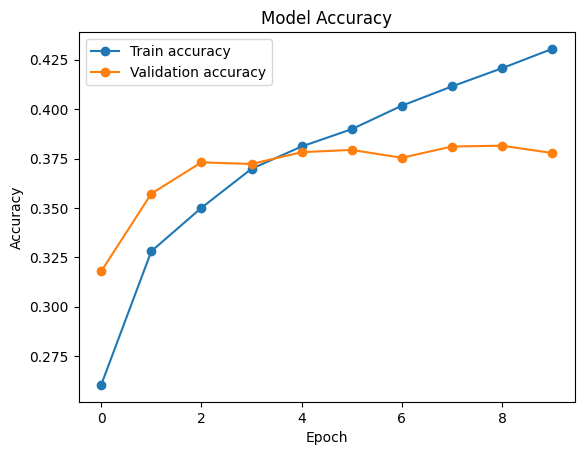

In [20]:
plt.plot(history.history["accuracy"], label = 'Train accuracy', marker='o')
plt.plot(history.history["val_accuracy"], label = 'Validation accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

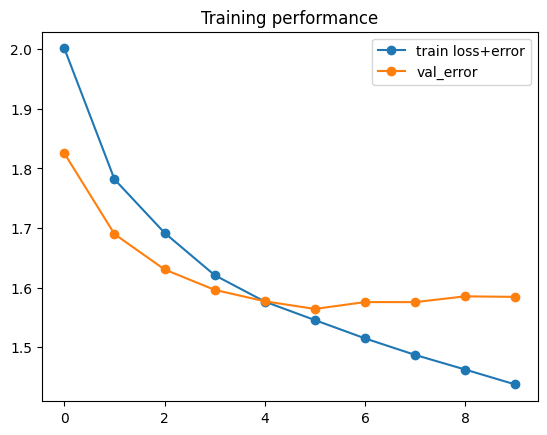

In [21]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error', marker='o')
plt.plot(history.epoch, history.history['val_loss'], label='val_error', marker='o')
plt.legend()

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

23/23 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-20:  0.09386281588447654
23/23 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-18:  0.09078529278256922
22/22 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-16:  0.09575923392612859
22/22 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-14:  0.0974264705882353
23/23 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-12:  0.10891976692066338
23/23 [==============================] - 0s 6ms/step
Overall Accuracy for SNR=-10:  0.13854895104895104
21/21 [==============================] - 0s 7ms/step
Overall Accuracy for SNR=-8:  0.19666666666666666
23/23 [==============================] - 0s 8ms/step
Overall Accuracy for SNR=-6:  0.2784014369106421
22/22 [==============================] - 0s 8ms/step
Overall Accuracy for SNR=-4:  0.36066350710900474
23/23 [==============================] - 0s 8ms/step
Overall Accuracy

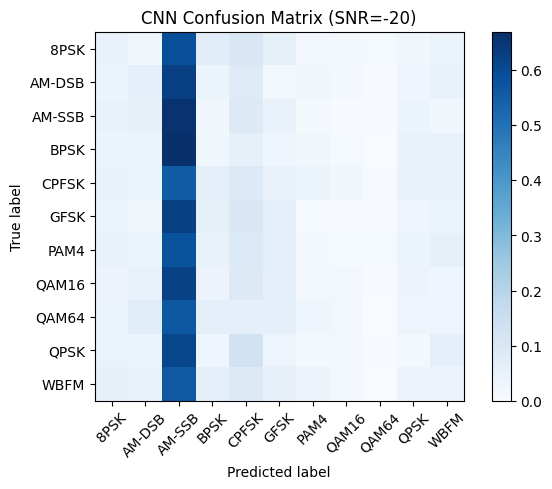

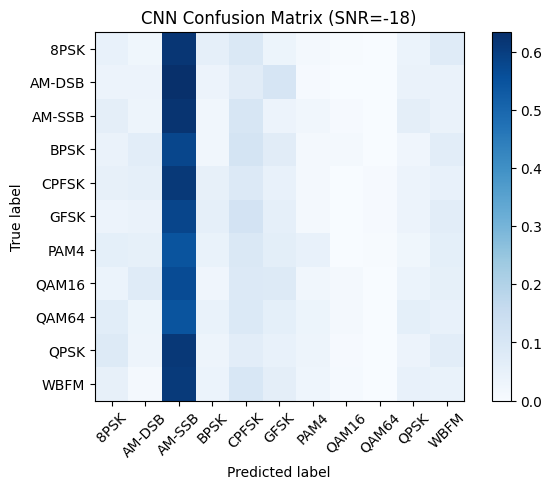

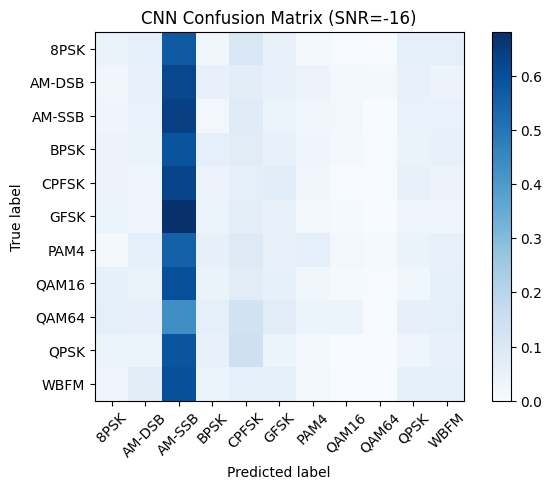

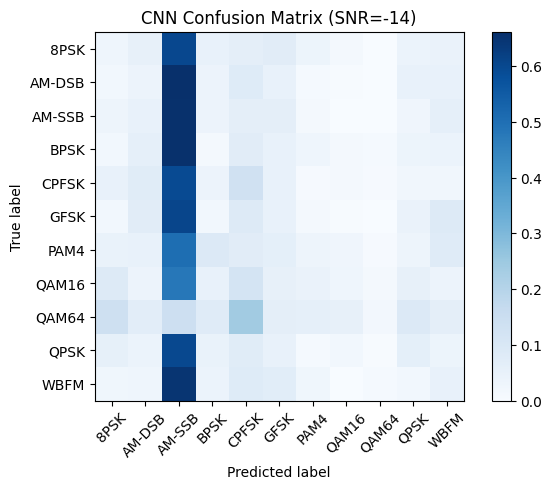

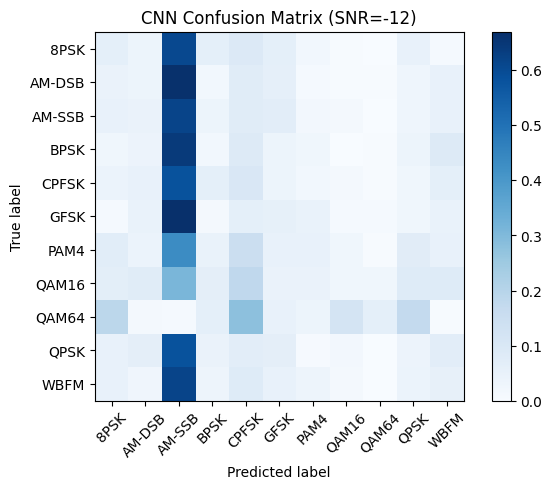

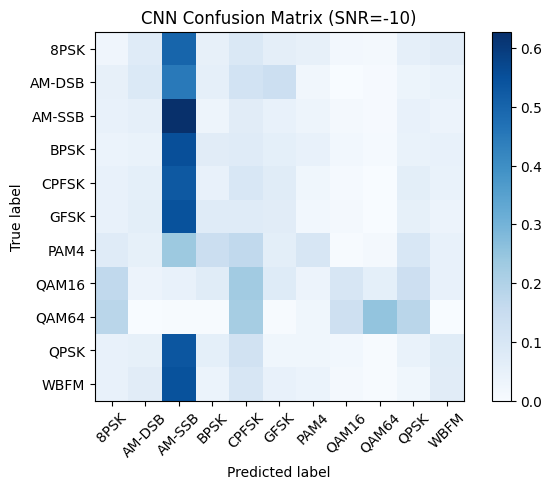

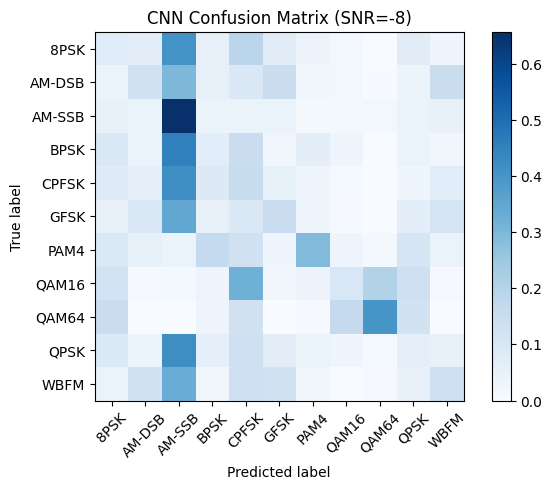

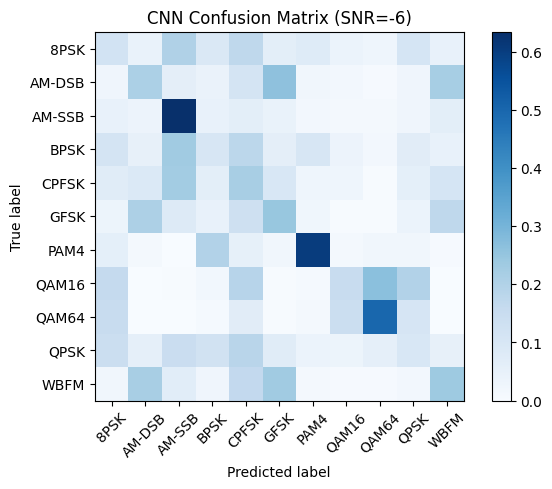

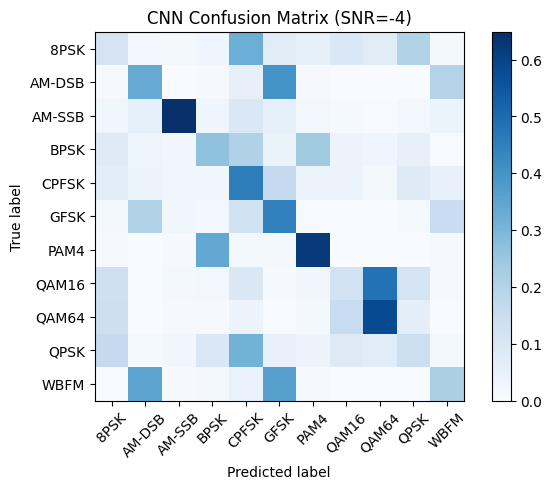

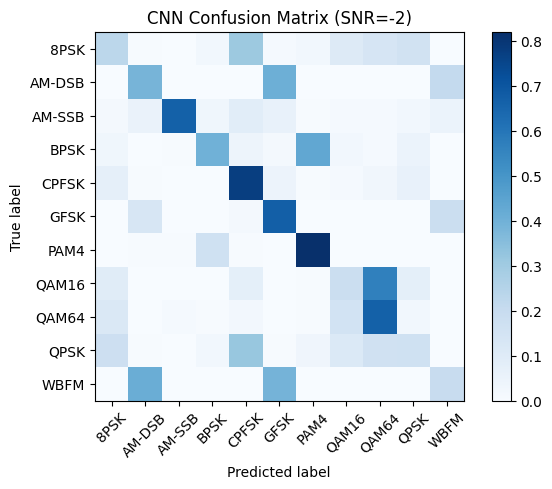

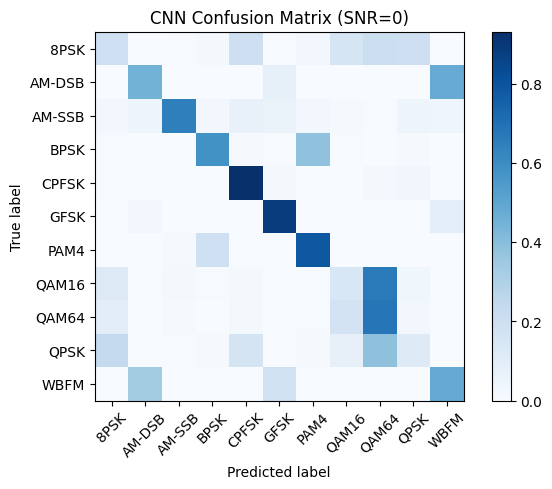

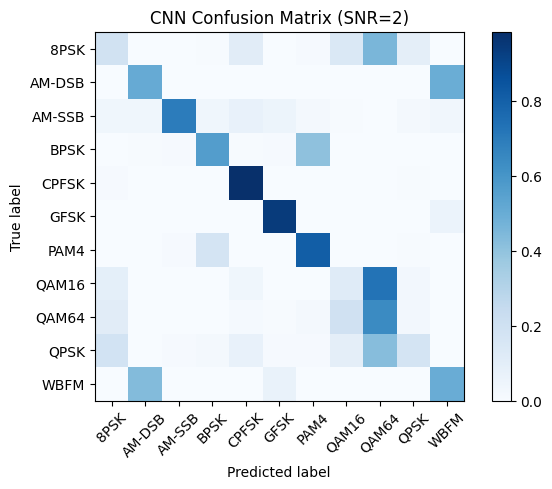

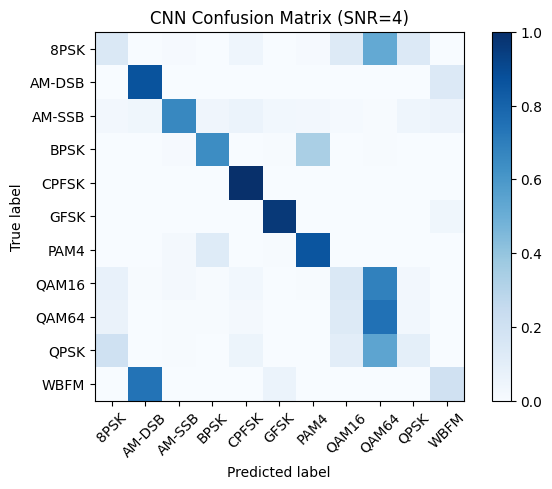

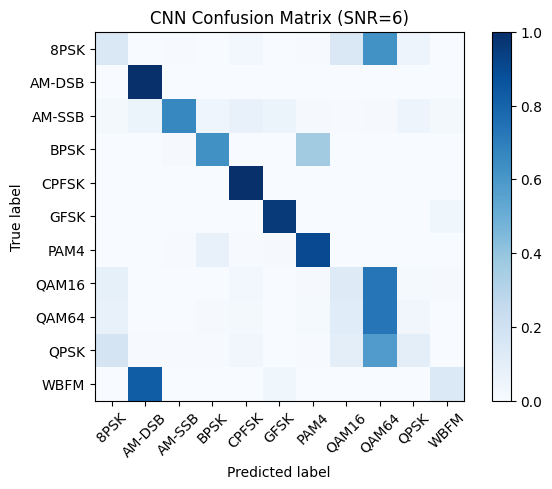

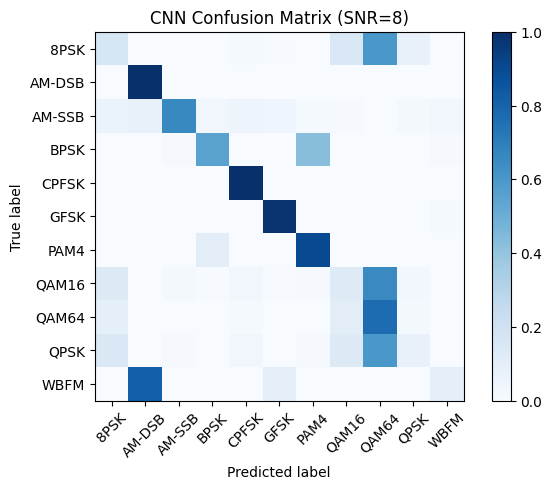

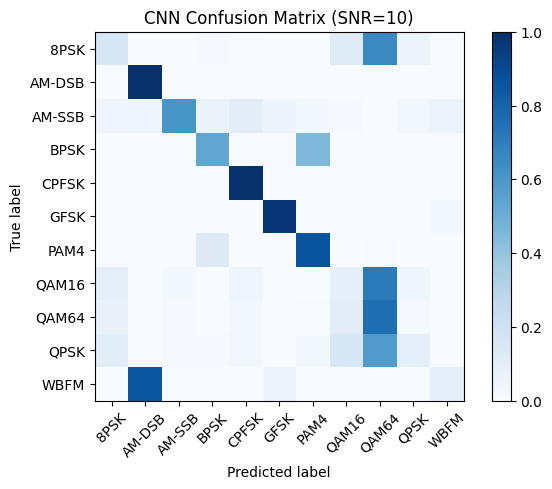

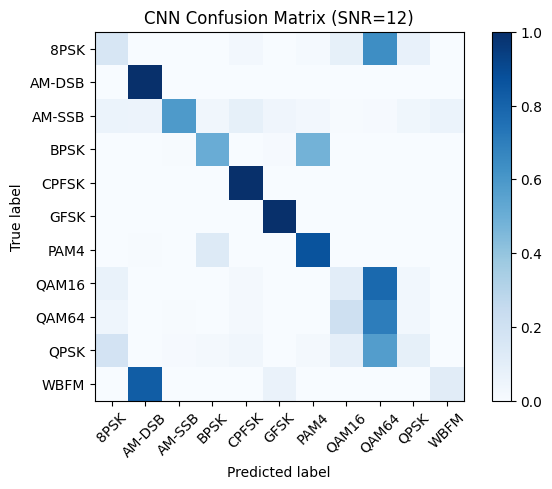

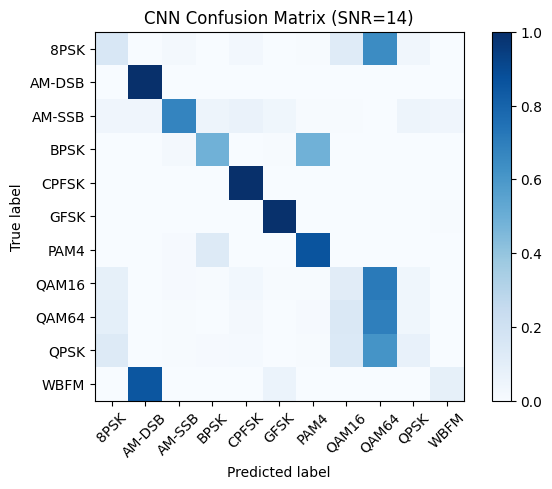

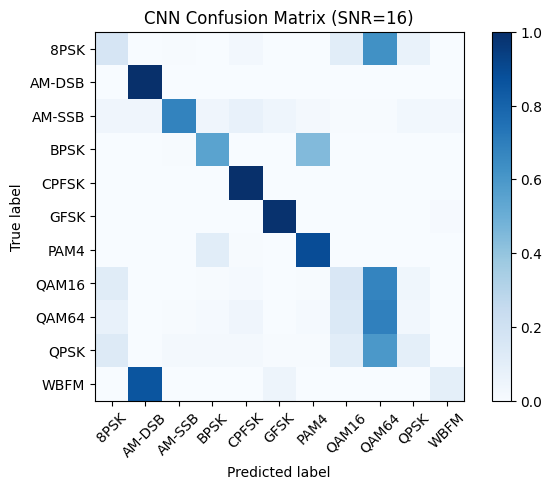

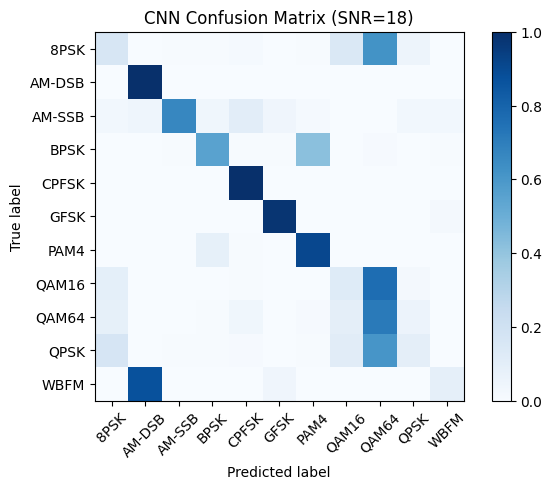

In [23]:
acc = {}
for snr in snrs:    
    test_SNRs = list(map(lambda x: labels[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_Y_hat = model.predict(test_X_i, batch_size=100)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="CNN Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy for SNR=%d: "%(snr), 1.0 * cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN Classification Accuracy')

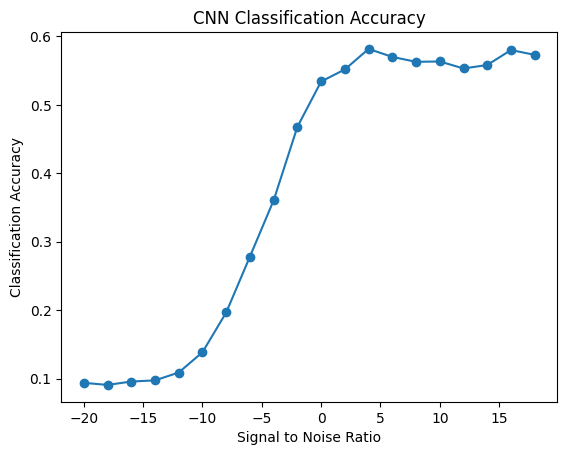

In [24]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)), marker='o')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy")